In [1]:
#Fine tunig a BERT model
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 41.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax-checkpoint 0.3.1 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.
tensorflow-datase

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're us

In [3]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [5]:
# pre-trained BERT encoder from TensorFlow Hub
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [6]:
# The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of sentence pairs automatically
# extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent.
glue, info = tfds.load('glue/mrpc', with_info=True,batch_size=-1)

Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/2.0.0. Subsequent calls will reuse this data.


In [7]:
list(glue.keys())

[Split('train'), Split('validation'), Split('test')]

In [8]:
info.features

FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=string),
    'sentence2': Text(shape=(), dtype=string),
})

In [9]:
info.features['label'].names

['not_equivalent', 'equivalent']

In [11]:
# understanding training example
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


In [21]:
# BERT tokenizer
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab)) #,
print(tokenizer.vocab['ideas'])
print(tokenizer.vocab['moving'])

Vocab size: 30522
4784
3048


In [23]:
# example of tokenizing the sentence
tokens = tokenizer.tokenize("What are you doing ?")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['what', 'are', 'you', 'doing', '?']
[2054, 2024, 2017, 2725, 1029]


In [24]:
# Preprocess the dataset into the format expected by the model
# The model expects its two inputs sentences to be concatenated together.
# This input is expected to start with a [CLS] "This is a classification problem"
# token, and each sentence should end with a [SEP] "Separator" token:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])


[101, 102]

In [25]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence1"]])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence2"]])

In [26]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [3668, None]
Sentence2 shape: [3668, None]


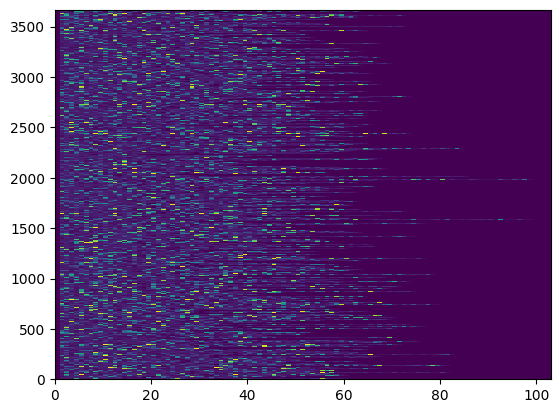

In [27]:
# Now prepend a [CLS] token, and concatenate the ragged tensors to form a single
# input_word_ids tensor for each example. RaggedTensor.to_tensor() zero pads to the longest sequence.
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

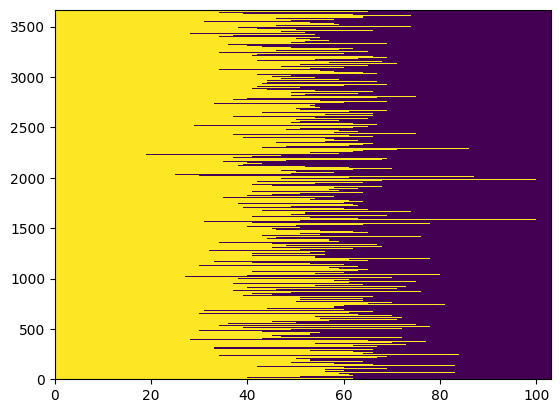

In [28]:
# Mask and input type
# The model expects two additional inputs:

# 1. The input mask
# 2. The input type
# The mask allows the model to cleanly differentiate between the content and the padding.
# The mask has the same shape as the input_word_ids, and contains a 1 anywhere the input_word_ids is not padding.

input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

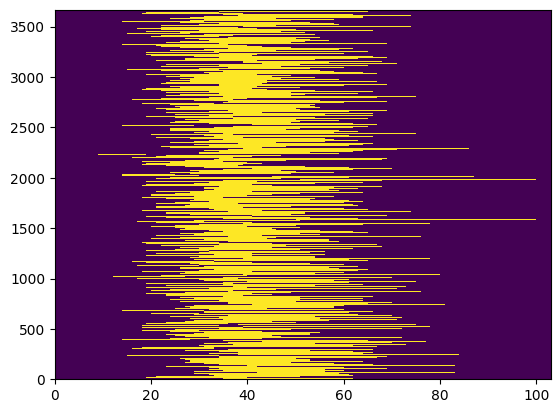

In [29]:
#The "input type" also has the same shape, but inside the non-padded region,
# contains a 0 or a 1 indicating which sentence the token is a part of.
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [30]:
# Put it all together
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])

  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [31]:
# Convert Each subset of the data to a dictionary of features, and a set of labels.
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

In [32]:
# Print the key value and shapes
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape: (3668,)


In [33]:
# Build the model
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [34]:
# The config defines the core BERT Model, which is a Keras model to predict the
# outputs of num_classes from the inputs with maximum sequence length max_seq_length.

# This function returns both the encoder and the classifier.
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

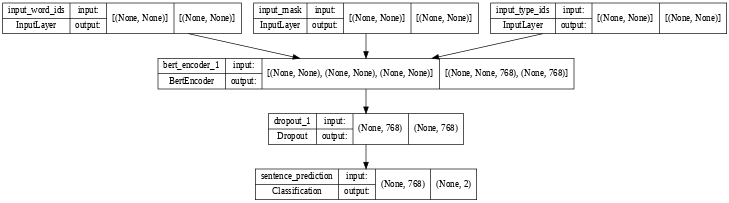

In [35]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [36]:
# Run it on a test batch of data 10 examples from the training set.
# The output is the logits for the two classes:

glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[-0.07040896,  0.15078695],
       [-0.00990168,  0.00599697],
       [-0.01227654,  0.10532521],
       [-0.03981125, -0.10842354],
       [-0.03587979, -0.10201287],
       [-0.15883347,  0.14483495],
       [-0.10654589, -0.06294534],
       [-0.0018804 ,  0.07834487],
       [-0.15844737, -0.08634214],
       [-0.15549496,  0.12601915]], dtype=float32)

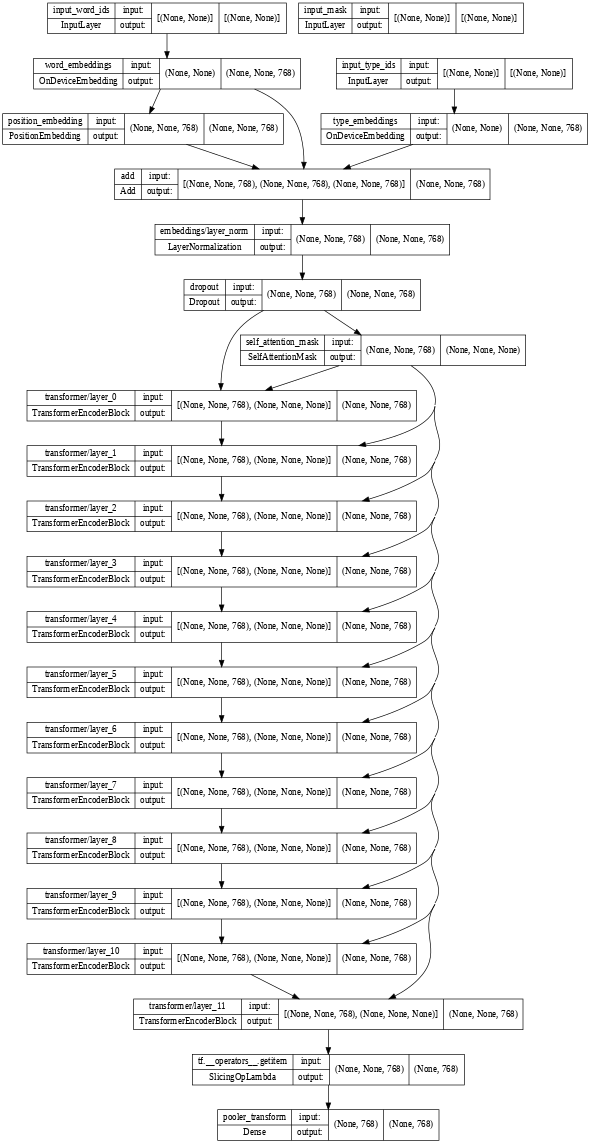

In [37]:
# Inspecting the encoder, we see its stack of Transformer layers connected to those same three inputs:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [38]:
# When built, the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [39]:
# Set the Optimizer
# BERT adopts the Adam optimizer with weight decay (aka "AdamW"). It also employs a
# learning rate schedule that firstly warms up from 0 and then decays to 0.
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [40]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [ ]:
# Train the model
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

# Train the model
bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

In [42]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

In [43]:
result = bert_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

array([1, 0])

In [44]:
np.array(info.features['label'].names)[result]


array(['equivalent', 'not_equivalent'], dtype='<U14')

In [45]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

In [46]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())

[[-0.23104681  1.0263774 ]
 [ 0.5802614  -0.20057161]]

[[-0.23104616  1.0263766 ]
 [ 0.58026147 -0.2005716 ]]
